In [2]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

In [3]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pickle

In [9]:
sys.path.append("..")

from WatChMaL.analysis.multi_plot_utils import multi_disp_learn_hist, multi_compute_roc, multi_plot_roc
from WatChMaL.analysis.comparison_utils import multi_get_masked_data, multi_collapse_test_output
from WatChMaL.analysis.fitqun_comparison_utils import load_fq_output, load_gamma_fq_output, load_mu_fq_output

In [10]:
############# define plotting params #############
c = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_dict = {"$\gamma$":0, "$e$":1, "$\mu$":2}
inverse_label_dict = {0:"$\gamma$", 1:"$e$", 2:"$\mu$"}
muon_softmax_index_dict = {"e/gamma":0, "mu":1}

## Load fitqun results

In [11]:
# Retrieve flags
gamma_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_gamma_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
e_file_path     = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_e-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'
mu_file_path    = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_mu-_E0to1000MeV_unif-pos-R400-y300cm_4pi-dir.fiTQun.root'

In [12]:
fq_mapping_path = '/home/jtindall/WatChMaL_analysis/fitqun_comparison/fq_comparison_data/3M_fitqun_mapping.pickle'

In [15]:
short_fq_scores, short_fq_labels, short_fq_mom, _ = load_mu_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path='w')

## Load resnet results

In [16]:
############# define run locations #############
short_locs = ['/home/jtindall/WatChMaL/outputs/2021-03-03/no_drop_last_full/outputs']

short_titles = ['Short Tank ResNet (3-Class)', 'Short Tank Fitqun']

full_locs = []

full_titles = []

short_linecolor = [c[0], c[1]]
short_linestyle = ['--' for _ in range(2)]

full_linecolor = [c[2], c[3]]
full_linestyle = [':' for _ in range(2)]


In [17]:
############# load short tank run data #############
short_idx_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_3M_OD_veto_idxs.npz'
short_indices = np.load(short_idx_file_path)['test_idxs']

short_raw_output_softmax    = [np.load(loc + "/softmax.npy") for loc in short_locs]
short_raw_actual_labels     = [np.load(loc + "/labels.npy") for loc in short_locs]

In [18]:
locs      = short_locs + full_locs
titles    = short_titles + full_titles
linecolor = short_linecolor + full_linecolor
linestyle = short_linestyle + full_linestyle

## Add fitqun results

In [19]:
short_raw_output_softmax = short_raw_output_softmax + [short_fq_scores]
short_raw_actual_labels  = short_raw_actual_labels + [short_fq_labels]

## Filter results

In [20]:
def remove_indices(array, cut_idxs):
    return np.delete(array, cut_idxs, 0)

with open('./fq_comparison_data/3M_fitqun_cuts.pickle', 'rb') as handle:
    cuts = pickle.load(handle)

cut_to_apply = cuts['fq_comparison']

In [21]:
short_softmax = [remove_indices(softmax, cut_to_apply) for softmax in short_raw_output_softmax]
short_labels  = [remove_indices(labels, cut_to_apply) for labels in short_raw_actual_labels]

## Plot electron comparison

In [22]:
short_collapsed_class_scores_list, short_collapsed_class_labels_list = multi_collapse_test_output(short_softmax, short_labels, label_dict, ignore_type='$\gamma$')

short_collapsed_class_labels_list = [collapsed_class_labels - 1 for collapsed_class_labels in short_collapsed_class_labels_list]
short_collapsed_class_scores_list = [collapsed_class_scores[:,1:] for collapsed_class_scores in short_collapsed_class_scores_list]

In [23]:
short_fpr_list, short_tpr_list, short_thr_list = multi_compute_roc(short_collapsed_class_scores_list, short_collapsed_class_labels_list, 
                            true_label=muon_softmax_index_dict["e/gamma"], 
                            false_label=muon_softmax_index_dict["mu"],
                            normalize=False)

## Combine Results and Plot

In [24]:
############# combine short and long results #############
fpr_list = short_fpr_list
tpr_list = short_tpr_list
thr_list = short_thr_list

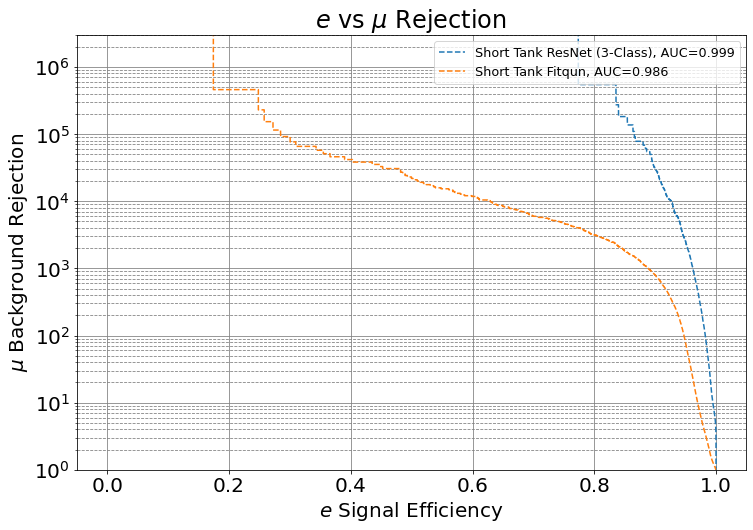

In [25]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\mu$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

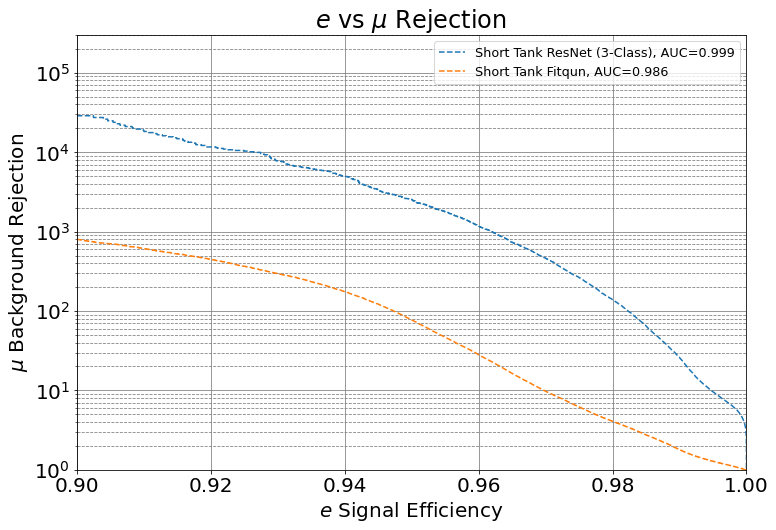

In [26]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\mu$",
                      fig_list=[1], xlims=[[0.9, 1.0]], ylims=[[1,3e5]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

## Gamma ROC Comparison

### Plot Old Discriminant

In [27]:
short_fpr_list, short_tpr_list, short_thr_list = multi_compute_roc(short_softmax, short_labels, 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=False)

In [28]:
fpr_list = short_fpr_list
tpr_list = short_tpr_list
thr_list = short_thr_list

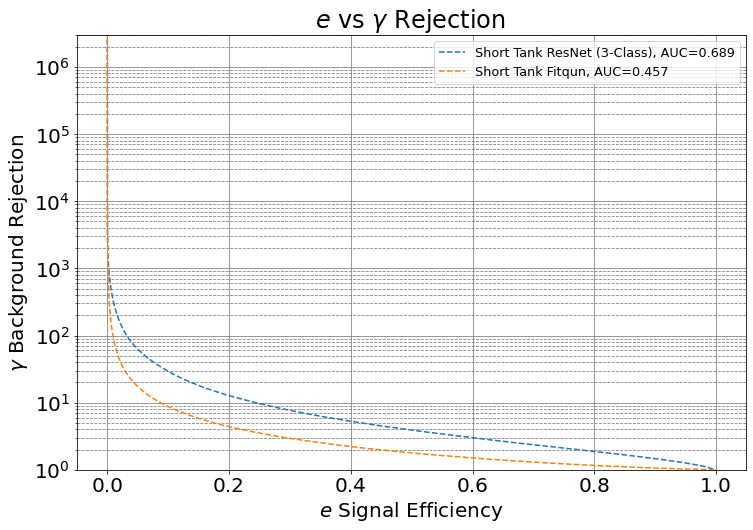

In [29]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

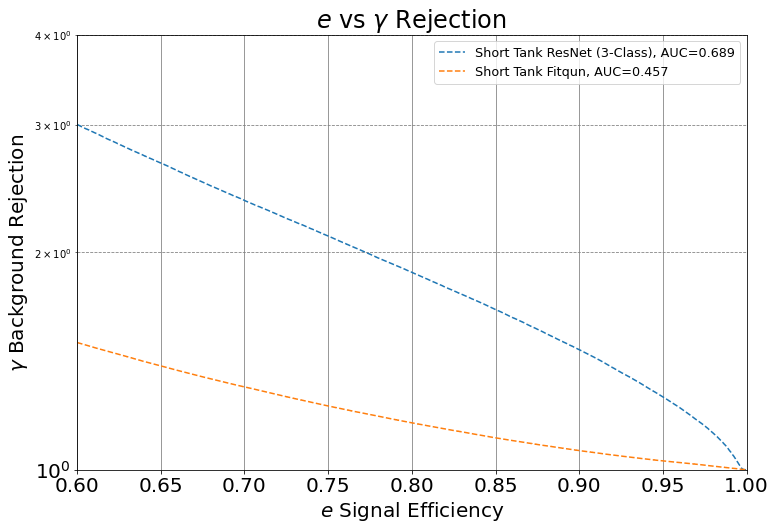

In [30]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$",
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

### Load fitqun results

In [32]:
short_fq_scores, short_fq_labels, short_fq_mom = load_gamma_fq_output(fq_mapping_path, gamma_file_path, e_file_path, mu_file_path, pion_file_path='w')

ValueError: too many values to unpack (expected 3)

### Load resnet results

In [ ]:
############# load short tank run data #############
short_idx_file_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_3M_OD_veto_idxs.npz'
short_indices = np.load(short_idx_file_path)['test_idxs']

short_raw_output_softmax    = [np.load(loc + "/softmax.npy") for loc in short_locs]
short_raw_actual_labels     = [np.load(loc + "/labels.npy") for loc in short_locs]

### Add fitqun results

In [ ]:
short_raw_output_softmax = short_raw_output_softmax + [short_fq_scores]
short_raw_actual_labels  = short_raw_actual_labels + [short_fq_labels]

### Filter results

In [ ]:
short_softmax = [remove_indices(softmax, cut_to_apply) for softmax in short_raw_output_softmax]
short_labels  = [remove_indices(labels, cut_to_apply) for labels in short_raw_actual_labels]

In [ ]:
short_fpr_list, short_tpr_list, short_thr_list = multi_compute_roc(short_softmax, short_labels, 
                            true_label=label_dict["$e$"], 
                            false_label=label_dict["$\gamma$"],
                            normalize=False)

In [ ]:
fpr_list = short_fpr_list
tpr_list = short_tpr_list
thr_list = short_thr_list

In [ ]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

In [ ]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\gamma$",
                      fig_list=[1], xlims=[[0.6, 1.0]], ylims=[[1,4e0]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

## Pi0 ROC Comparison (Preliminary)

In [ ]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\mu$", 
                      fig_list=[1], ylims=[[1,3e6]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)

In [ ]:
figs = multi_plot_roc(fpr_list, tpr_list, thr_list, "$e$", "$\mu$",
                      fig_list=[1], xlims=[[0.9, 1.0]], ylims=[[1,3e5]], 
                      linestyles=linestyle,linecolors=linecolor, plot_labels=titles, show=False)